In [1]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings(action='ignore')

In [2]:
TEST_SIZE = 0.4
FIG_SIZE = (8, 8)
RANDOM_STATE = 1
CORRELATION_THRESHOLD = 0.9
COLUMN_FOR_CLASSIFICATION = 'koi_pdisposition'


In [3]:
df = pd.read_csv('../data/cumulative_2025.10.03_12.03.43.csv')
df.tail()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9560,9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220
9562,9563,10155286,K07988.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.092,0,...,1.320,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460
9563,9564,10156110,K07989.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,3.300,1.100,3.400,1.100,0.960,0.670,3.400,1.100,3.500,1.100


In [4]:
label_encoder = LabelEncoder()
df[COLUMN_FOR_CLASSIFICATION] = label_encoder.fit_transform(
    df[COLUMN_FOR_CLASSIFICATION]
)

class_names = label_encoder.classes_
for idx, cls in enumerate(class_names):
    print(idx, cls, df[df[COLUMN_FOR_CLASSIFICATION] == idx].shape[0])


0 CANDIDATE 4717
1 FALSE POSITIVE 4847


In [5]:
# Remove all string columns
df = df.select_dtypes(include=[np.number])

# Remove all columns with null values
df = df.dropna(axis=1)

# Remove identifier columns
df = df.drop(columns=['rowid', 'kepid'], axis=1)

In [6]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
to_drop = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > CORRELATION_THRESHOLD)
]
df.drop(to_drop, axis=1, inplace=True)

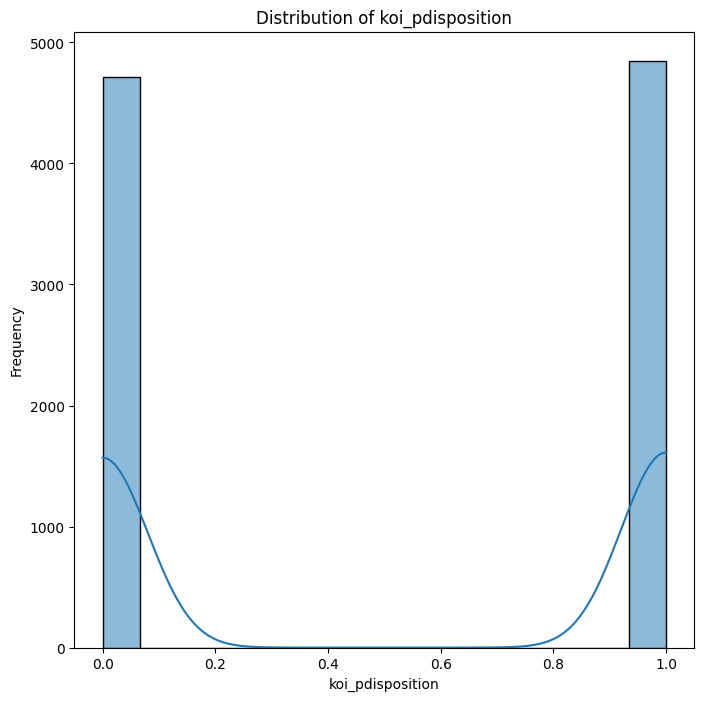

In [7]:
def plot_distribution(df: pd.DataFrame, col: str):
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


plot_distribution(df, COLUMN_FOR_CLASSIFICATION)

<Axes: >

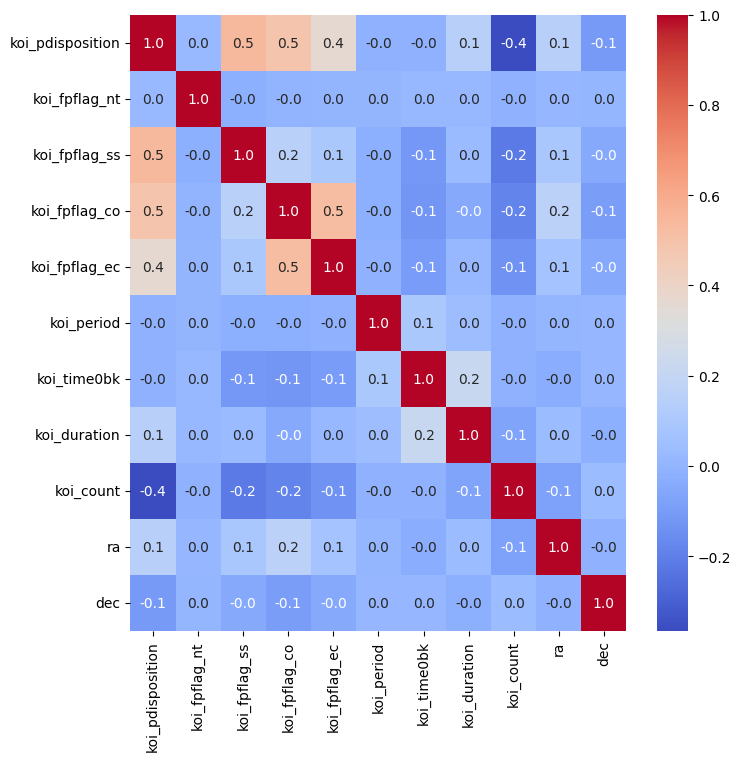

In [8]:
plt.figure(figsize=FIG_SIZE)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')

In [9]:
y = df[COLUMN_FOR_CLASSIFICATION]
X = df.drop(columns=[COLUMN_FOR_CLASSIFICATION], axis=1)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   koi_fpflag_nt  9564 non-null   int64  
 1   koi_fpflag_ss  9564 non-null   int64  
 2   koi_fpflag_co  9564 non-null   int64  
 3   koi_fpflag_ec  9564 non-null   int64  
 4   koi_period     9564 non-null   float64
 5   koi_time0bk    9564 non-null   float64
 6   koi_duration   9564 non-null   float64
 7   koi_count      9564 non-null   int64  
 8   ra             9564 non-null   float64
 9   dec            9564 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 747.3 KB


In [11]:
X.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_duration,koi_count,ra,dec
0,0,0,0,0,9.488036,170.538750,2.95750,2,291.93423,48.141651
1,0,0,0,0,54.418383,162.513840,4.50700,2,291.93423,48.141651
2,0,0,0,0,19.899140,175.850252,1.78220,1,297.00482,48.134129
3,0,1,0,0,1.736952,170.307565,2.40641,1,285.53461,48.285210
4,0,0,0,0,2.525592,171.595550,1.65450,1,288.75488,48.226200


In [12]:
imputer = SimpleImputer(strategy='median')
imputed_features = imputer.fit_transform(X)
X = pd.DataFrame(imputed_features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features)

In [13]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)

print(f'Training accuracy: {rf_clf.score(X_train, y_train) * 100:3.2f}%')
print(f'Testing accuracy: {rf_clf.score(X_test, y_test) * 100:3.2f}%')

Training accuracy: 100.00%
Testing accuracy: 98.72%


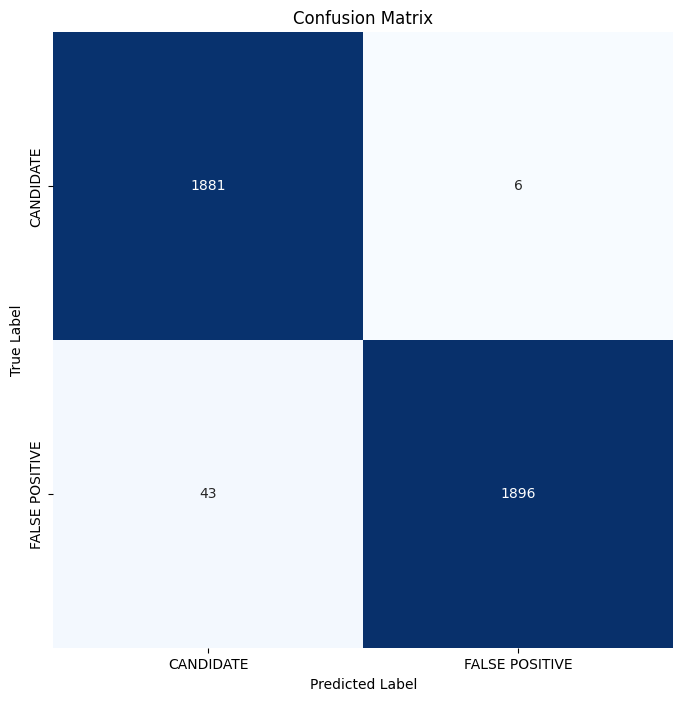

In [15]:
cf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))

plt.figure(figsize=FIG_SIZE)
sns.heatmap(
    cf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

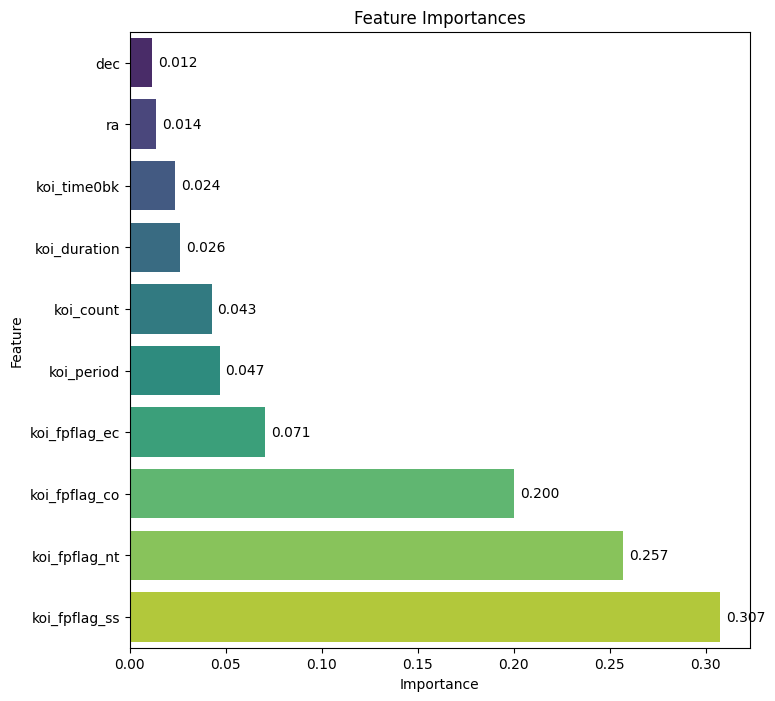

In [16]:
feature_names = df.drop(columns=[COLUMN_FOR_CLASSIFICATION]).columns.tolist()
importances = rf_clf.feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=FIG_SIZE)
ax = sns.barplot(x=feat_series.values, y=feat_series.index, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
for i, v in enumerate(feat_series.values):
    ax.text(v + max(feat_series.values) * 0.01, i, f'{v:.3f}', va='center')

plt.show()

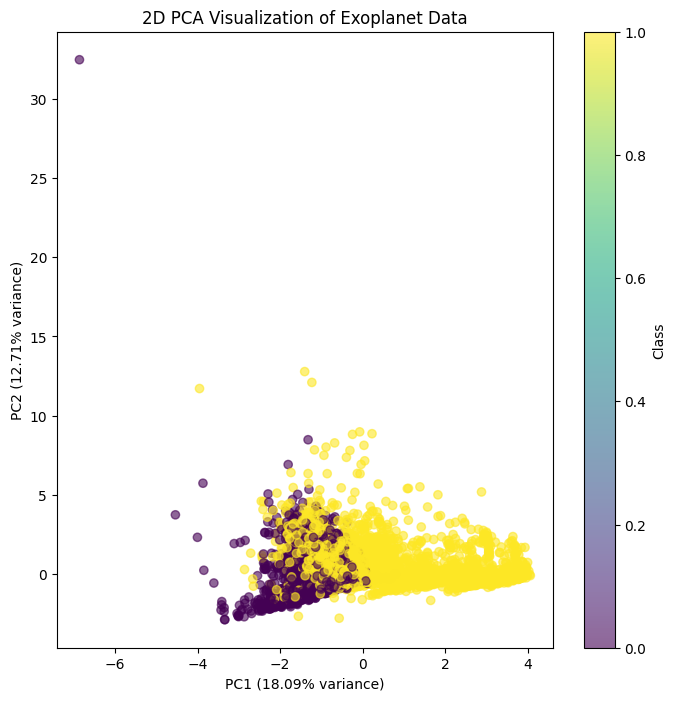

In [17]:
from sklearn.decomposition import PCA

# Apply PCA with 2 components
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X)

# Create 2D PCA plot
plt.figure(figsize=FIG_SIZE)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Class')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('2D PCA Visualization of Exoplanet Data')
plt.show()

In [18]:
os.makedirs('./models', exist_ok=True)
joblib.dump(rf_clf, './models/rf_cumulative.pkl')

['./models/rf_cumulative.pkl']